In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import sys
import pyabc
import seaborn as sns

import healpy as hp
from scipy.special import sph_harm
import fitsio
import skyproj
from astropy.coordinates import SkyCoord, Angle
import astropy.units as u

sys.path.insert(0, '/home/aew492/lss-dipoles/code')
import tools
import dipole
import multipoles
import generate_mocks as gm

### helper function

### Likelihood
From Hogg,
$$
\ln\mathcal{L} = \sum_i (y_i \ln \mu_i) - \sum_i \mu_i
$$
where $y_i$ is the data and $\mu_i$ is the expectation in pixel $i$. $\mu$ is a function of dipole amplitude.

In [4]:
# likelihood (from Hogg)
def lnlikelihood(data, expectation):
    assert data.shape == expectation.shape, "data and expectation must have the same shape"
    term1 = data * np.log(expectation)
    return np.nansum(term1), np.nansum(expectation)

In [5]:
# expectation function: dipole
def expected_dipole_map(dipamp, monopole=0., mask=None):
    comps = np.append(monopole, dipole.cmb_dipole(amplitude=dipamp, return_comps=True))
    dipole_map = dipole.dipole_map(comps)
    if mask is not None:
        dipole_map *= mask
    dipole_map[dipole_map == 0.] = np.nan
    return dipole_map

#### Quaia G20.0 fiducial

In [6]:
# load data
nside_hi = 64
blim = 30
resdir = '/scratch/aew492/lss-dipoles_results/results'

# selfunc
selfunc_quaia = gm.get_selfunc_map('quaia_G20.0_zodi', nside=nside_hi, blim=blim)

# masked map
quaia_qmap = np.load(os.path.join(resdir, '../data/catalogs/quaia/quaia_G20.0_masked.npy'))
# correct by selfunc
quaia_qmap_corr = quaia_qmap / selfunc_quaia
quaia_qmap_corr[np.isnan(quaia_qmap_corr)] = 0.

In [7]:
# expected dipole map
expected_dipamp = 0.0052
base_rate_quaia = 33.6330  # base rate for mocks
mask = (selfunc_quaia != 0.)

expectation = expected_dipole_map(expected_dipamp, base_rate_quaia, mask=mask)

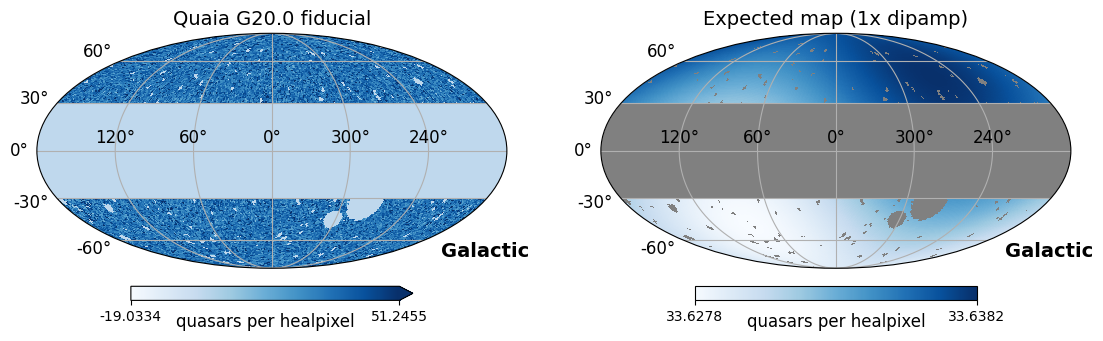

In [8]:
# plot the data vs expectation for 1x dipole

fig = plt.figure(figsize=(11,4))
kwargs = dict(coord=['C','G'], cmap=sns.color_palette("Blues", as_cmap=True),
              unit='quasars per healpixel', fig=fig, graticule=True, graticule_labels=True)#, badcolor='w')
mean, std = np.nanmean(quaia_qmap_corr), np.nanstd(quaia_qmap_corr)
hp.projview(quaia_qmap_corr, min=mean-2*std, max=mean+2*std, title='Quaia G20.0 fiducial', sub=(1,2,1), **kwargs)
tools.label_coord('Galactic', fs=14)

hp.projview(expectation, title='Expected map (1x dipamp)', sub=(1,2,2), **kwargs)
tools.label_coord('Galactic', fs=14)

In [9]:
dipamp_grid = expected_dipamp * np.linspace(0.5, 100., 20)
term1s = np.empty_like(dipamp_grid)
term2s = np.empty_like(dipamp_grid)
for i, dipamp in enumerate(dipamp_grid):
    print(f'{(i + 1) / len(dipamp_grid) * 100:.0f}%', end='\r')
    term1s[i], term2s[i] = lnlikelihood(quaia_qmap_corr, expected_dipole_map(dipamp, base_rate_quaia, mask=mask))
lnlikelihoods = term1s - term2s

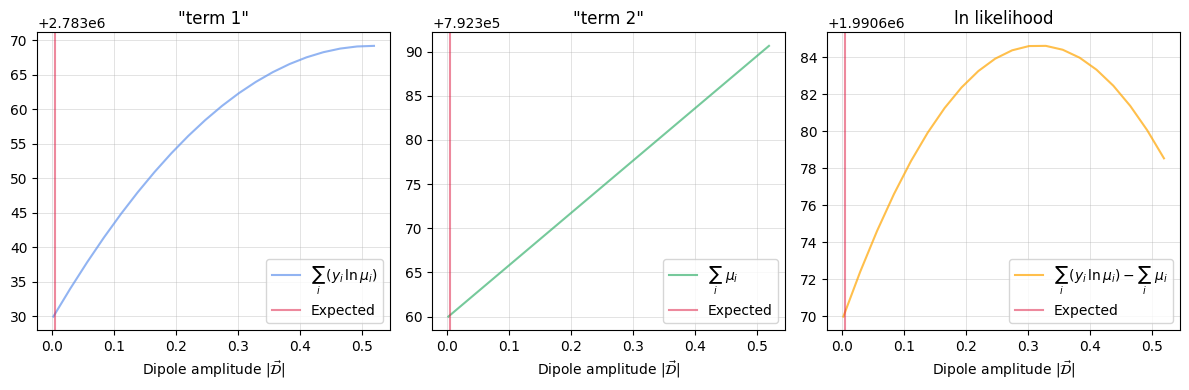

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), tight_layout=True)
axs[0].plot(dipamp_grid, term1s, c='cornflowerblue', alpha=0.7, label=r'$\sum_i\,(y_i\,\ln\mu_i)$')
axs[0].set_title('"term 1"')
axs[1].plot(dipamp_grid, term2s, c='mediumseagreen', alpha=0.7, label='$\sum_i\ \mu_i$')
axs[1].set_title('"term 2"')
axs[2].plot(dipamp_grid, lnlikelihoods, c='orange', alpha=0.7, label='$\sum_i\,(y_i\,\ln\mu_i) - \sum_i\ \mu_i$')
axs[2].set_title('ln likelihood')
for ax in axs:
    ax.axvline(expected_dipamp, c='crimson', alpha=0.5, label='Expected')
    ax.set_xlabel(r'Dipole amplitude $|\vec{\mathcal{D}}|$')
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend()

In [11]:
# what is the max likelihood?
imax = np.argmax(lnlikelihoods)
max_lnlik_dipamp = dipamp_grid[imax]
print(f"maximum ln likelihood occurs at {max_lnlik_dipamp:.4f} = {max_lnlik_dipamp / expected_dipamp:.2f}x expected dipole amp.")

maximum ln likelihood occurs at 0.3294 = 63.34x expected dipole amp.


#### test this out with fake, more ideal data

In [12]:
# load fake data: Quaia G20.0-like, 1x expected dipole, zero excess power
sample_name = 'quaia_G20.0_zodi'
rel_input_dipamp = 1.
log_excess = 'zero'
label = f'fake Quaia G20.0 zodi ({rel_input_dipamp:.1f}x expected dipole, log excess = {log_excess})'
case_dir = os.path.join(resdir, f'ABC/fake_data',
                            f'{sample_name}_base-rate-{base_rate_quaia:.4f}_dipamp-{rel_input_dipamp:.1f}x_excess-{log_excess}')

In [13]:
fake_data = np.load(os.path.join(case_dir, 'fake_data.npy'), allow_pickle=True).item()
qmap = fake_data['data']['data'].astype(float)
qmap[qmap == 0.] = np.nan
qmap_corr = qmap / fake_data['selfunc']

Text(0.5, 1.0, 'fake Quaia G20.0 zodi (1.0x expected dipole, log excess = zero)')

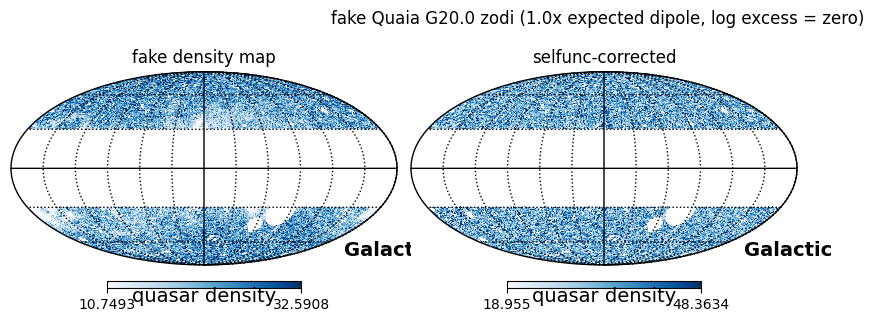

In [14]:
fig = plt.figure(figsize=(12,3))
kwargs = dict(coord=['C','G'], unit='quasar density', badcolor='w', cmap='Blues')
mean, std = np.nanmean(qmap), np.nanstd(qmap)
hp.mollview(qmap, title='fake density map', sub=(1,3,1), min=mean-2 * std, max=mean+2 * std, **kwargs)
mean, std = np.nanmean(qmap_corr), np.nanstd(qmap_corr)
hp.mollview(qmap_corr, title='selfunc-corrected', sub=(1,3,2), min=mean-2 * std, max=mean+2 * std, **kwargs)
hp.graticule()
fig.suptitle(label, y=1.)

In [15]:
dipamp_grid = expected_dipamp * np.linspace(0.5, 100., 100)
term1s = np.empty_like(dipamp_grid)
term2s = np.empty_like(dipamp_grid)
for i, dipamp in enumerate(dipamp_grid):
    print(f'{(i + 1) / len(dipamp_grid) * 100:.0f}%', end='\r')
    term1s[i], term2s[i] = lnlikelihood(qmap_corr, expected_dipole_map(dipamp, base_rate_quaia, mask=mask))
lnlikelihoods = term1s - term2s

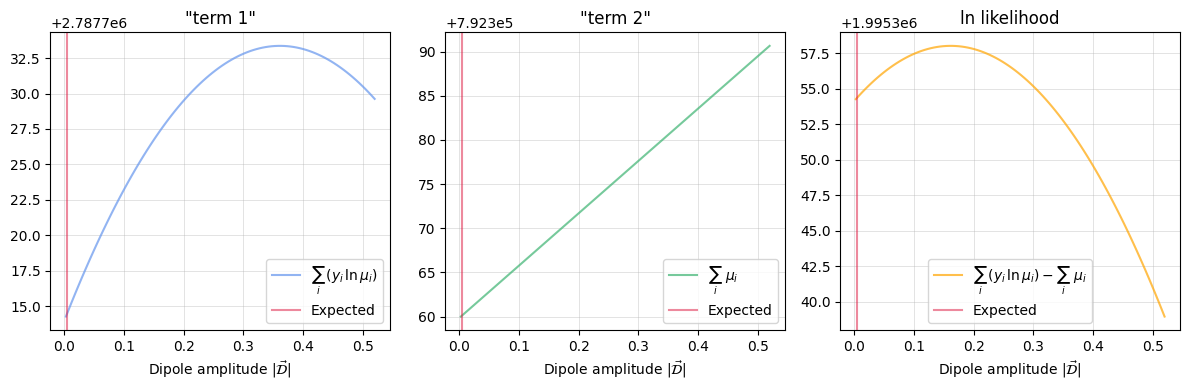

In [16]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), tight_layout=True)
axs[0].plot(dipamp_grid, term1s, c='cornflowerblue', alpha=0.7, label=r'$\sum_i\,(y_i\,\ln\mu_i)$')
axs[0].set_title('"term 1"')
axs[1].plot(dipamp_grid, term2s, c='mediumseagreen', alpha=0.7, label='$\sum_i\ \mu_i$')
axs[1].set_title('"term 2"')
axs[2].plot(dipamp_grid, lnlikelihoods, c='orange', alpha=0.7, label='$\sum_i\,(y_i\,\ln\mu_i) - \sum_i\ \mu_i$')
axs[2].set_title('ln likelihood')
for ax in axs:
    ax.axvline(expected_dipamp, c='crimson', alpha=0.5, label='Expected')
    ax.set_xlabel(r'Dipole amplitude $|\vec{\mathcal{D}}|$')
    ax.grid(alpha=0.5, lw=0.5)
    ax.legend()

In [17]:
# what is the max likelihood?
imax = np.argmax(lnlikelihoods)
max_lnlik_dipamp = dipamp_grid[imax]
print(f"maximum ln likelihood occurs at {max_lnlik_dipamp:.4f} = {max_lnlik_dipamp / expected_dipamp:.2f}x expected dipole amp.")

maximum ln likelihood occurs at 0.1594 = 30.65x expected dipole amp.
